In [ ]:
import jax.numpy as jnp
import numpy as np
import numpyro
import numpyro.distributions as dist
from jax import random
import jax
from numpyro.infer import MCMC, NUTS
from scipy.special import logsumexp
import functools
import matplotlib.pyplot as plt

def gaussian_mixture_model(data, component_dim, num_component=2, sigma=1.0, prior_sigma=10.0, alpha=0.3):
    weights = numpyro.sample("weights", dist.Dirichlet(concentration=np.ones(num_component) * alpha))
    mus = [
        numpyro.sample(
            f"mu{i + 1}",
            dist.MultivariateNormal(
                loc=jnp.zeros((component_dim,)), 
                covariance_matrix=jnp.eye(component_dim) * prior_sigma
            )
        ) for i in range(num_components)
        
    ]
    with numpyro.plate("data", data.shape[0]):
        numpyro.sample(
            "obs", 
            dist.MixtureGeneral(
                mixing_distribution=dist.Categorical(probs=weights), 
                component_distributions=[
                    dist.MultivariateNormal(loc=mu, covariance_matrix=jnp.eye(component_dim) * sigma)
                    for mu in mus
                ]
            ), 
            obs=data
        )
    
def compute_bayesian_loss(loglike_fn, data, posterior_param_list):
    # dimension = (num test samples, num mcmc samples)
    loglike_array = np.hstack(
        [loglike_fn(param, data) for param in posterior_param_list]
    )
    num_mcmc_samples = loglike_array.shape[1]
    result = -np.mean(logsumexp(loglike_array, b=1 / num_mcmc_samples, axis=1))
    return result

def log_likelihood(params, data, component_dim, sigma=1.0):
    mukeys = sorted([key for key in params.keys() if key.startswith("mu")])
    mus = [params[key] for key in mukeys]
    weights = params["weights"]
    cov_matrix = jnp.eye(component_dim) * sigma
    component_densities = jnp.array(
        [
            dist.MultivariateNormal(loc=mu, covariance_matrix=cov_matrix).log_prob(data) 
            for mu in mus
        ]
    ).T
    log_probs = jnp.log(weights) + component_densities
    loglikes = logsumexp(log_probs, axis=-1, keepdims=True)
    return loglikes

(1000, 2)


sample: 100%|████████████████████████████████████████████| 3500/3500 [00:05<00:00, 681.14it/s, 15 steps of size 3.12e-01. acc. prob=0.91]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    mu1[0]      0.26      0.07      0.26      0.14      0.37    727.31      1.00
    mu1[1]      0.27      0.07      0.27      0.15      0.38    885.74      1.00
    mu2[0]     -0.86      0.18     -0.84     -1.13     -0.57    878.84      1.00
    mu2[1]     -0.83      0.16     -0.82     -1.09     -0.58    858.05      1.00
weights[0]      0.75      0.07      0.75      0.64      0.87    709.83      1.00
weights[1]      0.25      0.07      0.25      0.13      0.36    709.83      1.00

Number of divergences: 0


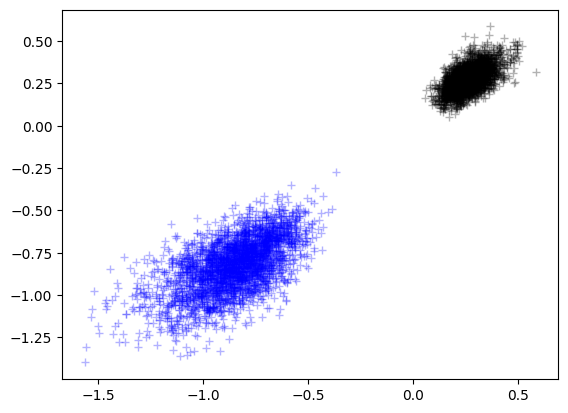

In [153]:
# Generate synthetic 2-dimensional data
component_dim = 2
num_components = 2
num_data = 1000
a0 = 0.5
delta = 0.5
b0 = np.ones(component_dim) * delta
c0 = -np.ones(component_dim) * delta
sigma = 1.0
prior_sigma = 10.0
alpha = 0.3

n1, n2 = list(map(int, num_data * np.array([a0, 1 - a0])))
data = np.concatenate([
    np.random.randn(n1, component_dim) * sigma + b0, 
    np.random.randn(n2, component_dim) * sigma + c0
])

print(data.shape)
# Set up and run MCMC
rng_key = random.PRNGKey(0)
kernel = NUTS(gaussian_mixture_model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=3000)
mcmc.run(rng_key, data, component_dim, num_components, init_params=None, )

# Get posterior samples
samples = mcmc.get_samples()
mcmc.print_summary()

mu1 = samples["mu1"]
mu2 = samples["mu2"]
plt.plot(mu1[:, 0], mu1[:, 1], "k+", alpha=0.3)
plt.plot(mu2[:, 0], mu2[:, 1], "b+", alpha=0.3)

In [150]:
num_mcmc_samples = len(samples[list(samples.keys())[0]])
posterior_param_list = [
    {key: samples[key][i] for key in samples.keys()} for i in range(num_mcmc_samples)
]

loglike_fn = functools.partial(log_likelihood, component_dim=component_dim, sigma=sigma)
# log_likelihood(samples, data, sigma)

In [148]:
%time compute_bayesian_loss(loglike_fn, data, posterior_param_list)

CPU times: user 4.37 s, sys: 11.8 ms, total: 4.38 s
Wall time: 4.38 s


3.055611228645629

In [145]:
loglike_array = np.hstack(
        [loglike_fn(param, data) for param in posterior_param_list]
    )

In [147]:
loglike_array.shape

(500, 3000)

In [144]:
loglike_fn(posterior_param_list[0], data)

array([[-5.279169 ],
       [-4.4909277],
       [-3.3792841],
       [-2.222254 ],
       [-3.088965 ],
       [-3.1970596],
       [-2.2463207],
       [-2.5051575],
       [-2.4878898],
       [-2.19101  ],
       [-3.371193 ],
       [-2.9718626],
       [-2.8044767],
       [-2.1821842],
       [-2.0939956],
       [-2.155691 ],
       [-2.1997252],
       [-3.059558 ],
       [-3.5833366],
       [-3.3020327],
       [-3.2440012],
       [-2.2398565],
       [-2.0693924],
       [-2.3730168],
       [-2.3575397],
       [-2.3161514],
       [-2.2034419],
       [-3.5193017],
       [-3.3417547],
       [-2.4517934],
       [-3.8290997],
       [-2.165649 ],
       [-2.4700963],
       [-3.4744391],
       [-2.2817836],
       [-2.3126888],
       [-2.6229246],
       [-3.5733027],
       [-3.0560095],
       [-2.6063826],
       [-2.4410498],
       [-2.2438645],
       [-3.8101218],
       [-8.0117855],
       [-2.238177 ],
       [-2.56867  ],
       [-2.4983099],
       [-2.40